In [1]:
import os, glob
import pandas as pd
import numpy as np
from model_utils import load_mat_file, extract_train_trials, extract_test_trials
from utils import *

fits_path = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehavioralModel-main/Fits"
mat_files = sorted(glob.glob(f"{fits_path}/*.mat"))

all_rat_data = {}

def add_session_numbers(df, ntrials):
    """Add session numbers to dataframe based on ntrials array"""
    if len(ntrials) == 0:
        df['session'] = 1
        return df

    # convert ntrials to numpy array and flatten if needed
    ntrials = np.array(ntrials).flatten()

    # calculate session start indices using cumulative sum
    session_starts = np.concatenate([[0], np.cumsum(ntrials[:-1])])

    # initialize session column
    df['session'] = 0

    # assign session numbers
    for i, (start_idx, n_trials) in enumerate(zip(session_starts, ntrials)):
        start_idx = int(start_idx)
        n_trials = int(n_trials)
        end_idx = start_idx + n_trials
        # Make sure we don't exceed dataframe length
        end_idx = min(end_idx, len(df))
        df.iloc[start_idx:end_idx, df.columns.get_loc('session')] = i + 1

    return df

for file in mat_files:
    rat = os.path.basename(file).split('.')[0]
    mat_data = load_mat_file(file)
    folds = mat_data.get('BestFit_Folds', [])

    # extract training and testing data
    train_df = extract_train_trials(folds, rat=rat)
    test_df = extract_test_trials(folds, rat=rat)

    # get ntrials for fold 0 from the correct location
    train_ntrials = []
    test_ntrials = []

    if len(folds) > 0:
        fold_0 = folds[0]
        # extract ntrials from training data using *fieldnames
        if hasattr(fold_0, 'ratTrial_TrainFold') and hasattr(fold_0.ratTrial_TrainFold, '_fieldnames'):
            train_fieldnames = fold_0.ratTrial_TrainFold._fieldnames
            if 'ntrials' in train_fieldnames:
                train_ntrials_idx = list(train_fieldnames).index('ntrials')
                train_ntrials = fold_0.ratTrial_TrainFold.ntrials
                if hasattr(train_ntrials, 'flatten'):
                    train_ntrials = train_ntrials.flatten()

        # extract ntrials from test data using *fieldnames
        if hasattr(fold_0, 'ratTrial_TestFold') and hasattr(fold_0.ratTrial_TestFold, '_fieldnames'):
            test_fieldnames = fold_0.ratTrial_TestFold._fieldnames
            if 'ntrials' in test_fieldnames:
                test_ntrials_idx = list(test_fieldnames).index('ntrials')
                test_ntrials = fold_0.ratTrial_TestFold.ntrials
                if hasattr(test_ntrials, 'flatten'):
                    test_ntrials = test_ntrials.flatten()

    # get fold 0 data
    train_fold_0 = train_df[train_df['Fold'] == 0].copy()
    test_fold_0 = test_df[test_df['Fold'] == 0].copy()

    # concatenate train and test data
    combined_df = pd.concat([train_fold_0, test_fold_0], ignore_index=True)

    # concatenate the ntrials arrays (train first, then test)
    all_ntrials = []
    if len(train_ntrials) > 0:
        all_ntrials.extend(train_ntrials)
    if len(test_ntrials) > 0:
        all_ntrials.extend(test_ntrials)

    # add session numbers to the combined dataframe
    if len(combined_df) > 0 and len(all_ntrials) > 0:
        combined_df = add_session_numbers(combined_df, all_ntrials)
    elif len(combined_df) > 0:
        # if no ntrials info, assign all trials to session 1
        combined_df['session'] = 1

    combined_df = combined_df.rename(columns={'session': 'session_num'})
    
    # add transition columns and z-scored wait time column
    combined_df = get_transition_dynamics_from_df(combined_df)

    combined_df = combined_df[combined_df['wait_time'] <= 30].copy()
    combined_df['z_wait_time'] = (
        combined_df.groupby('reward')['wait_time']
        .transform(lambda x: (x - x.mean()) / x.std())
    )
    combined_df['transition_type'] = identify_transition_types(combined_df)

    all_rat_data[rat] = combined_df

In [2]:
from utils import identify_transition_types

for rat_id, df in all_rat_data.items():
    transition_labels = identify_transition_types(df)
    df["transition_type"] = transition_labels 

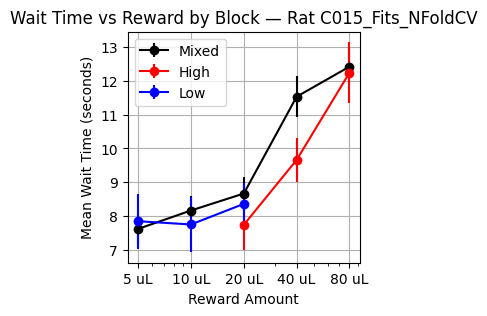

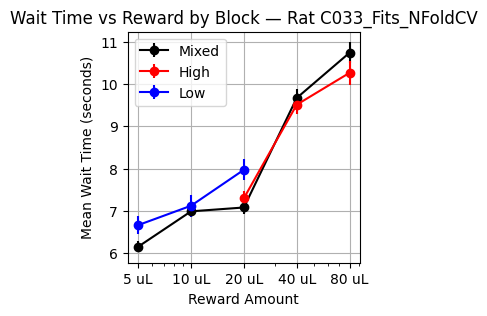

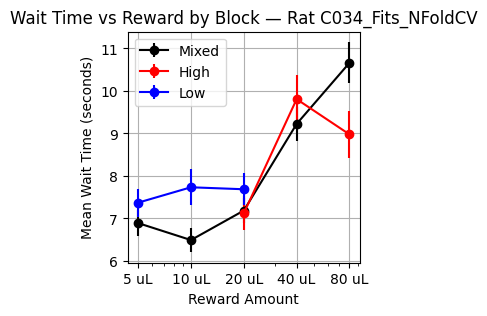

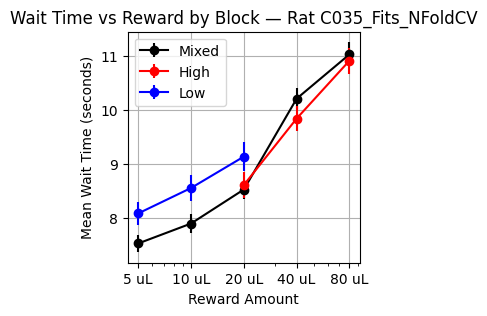

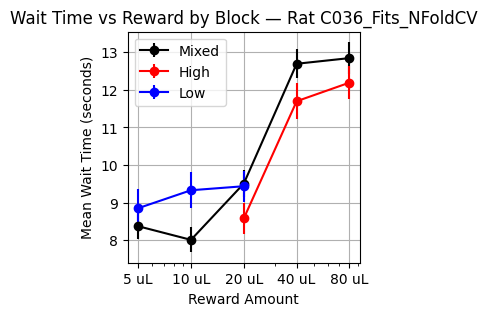

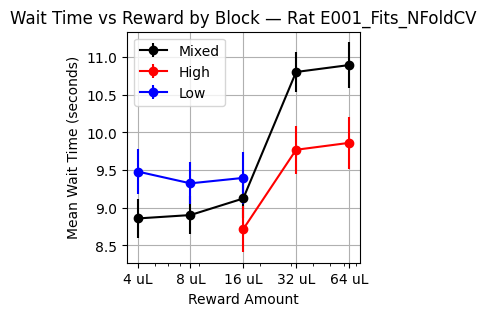

In [5]:
from utils import plot_wait_times_aggrgated
import matplotlib.pyplot as plt

shown = 0
for rat, df in all_rat_data.items():
    if shown >= 6:
        break
    plot_wait_times_aggrgated(df)
    plt.title(f"Wait Time vs Reward by Block — Rat {rat}")
    plt.show()
    shown += 1

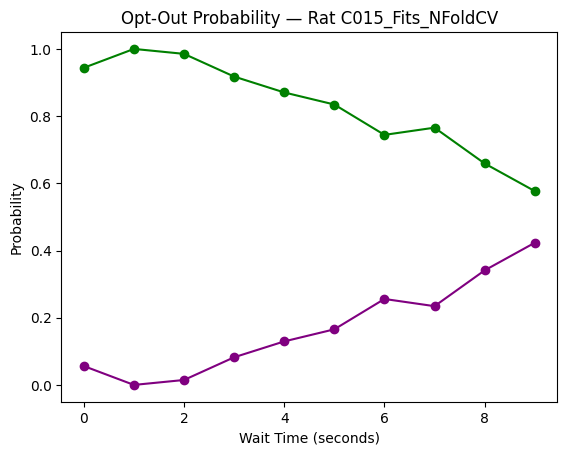

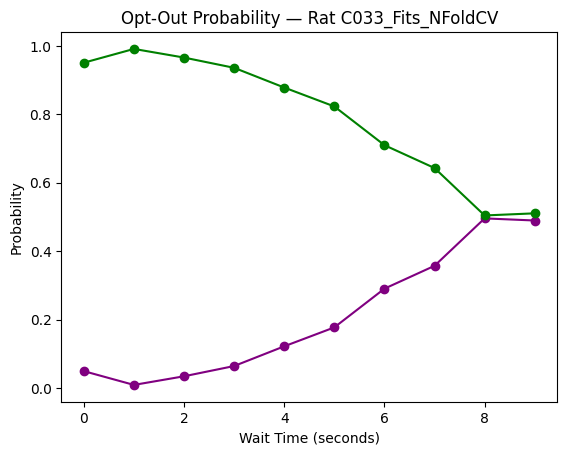

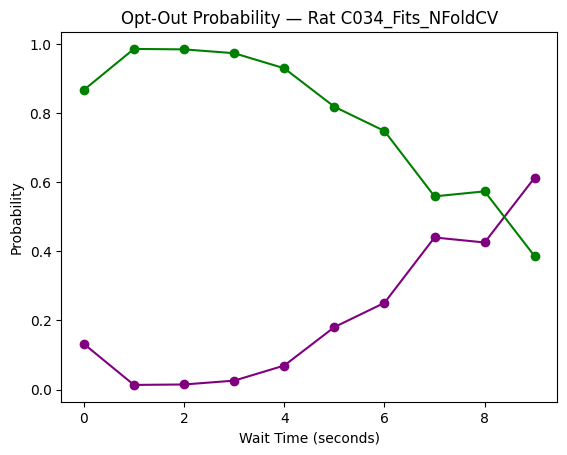

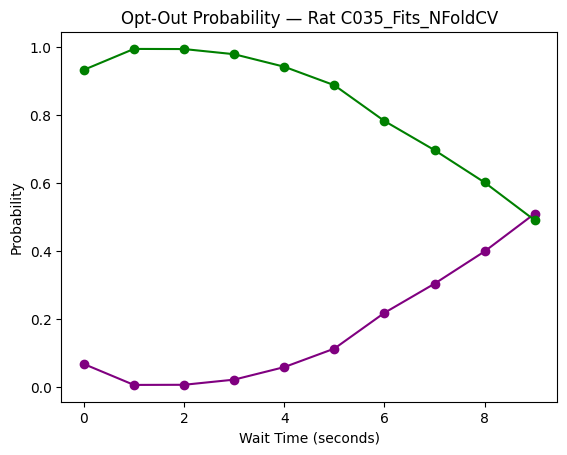

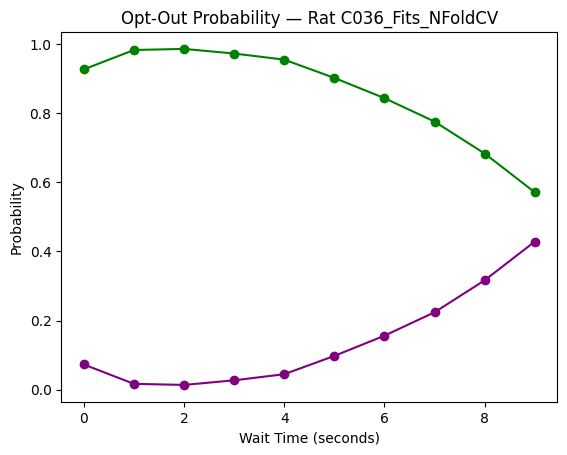

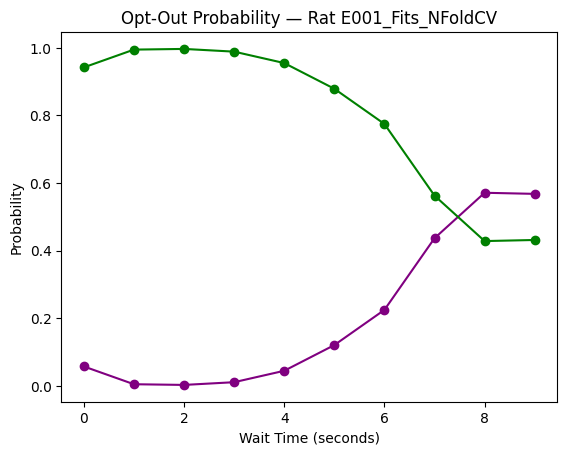

In [6]:
from utils import get_optout_probability

shown = 0
for rat, df in all_rat_data.items():
    if shown >= 6:
        break
    fig, ax = plt.subplots()
    get_optout_probability(df, ax=ax)
    ax.set_title(f"Opt-Out Probability — Rat {rat}")
    plt.show()
    shown += 1

In [7]:
import numpy as np

max_trials = 15
x_vals = np.arange(-max_trials, max_trials + 1)
transition_types = ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']
aligned_z_waits = {rat: {t: [] for t in transition_types} for rat in all_rat_data}

for rat, df in all_rat_data.items():
    for ttype in transition_types:
        transition_idxs = df[df['transition_type'] == ttype].index

        for idx in transition_idxs:
            start = idx - max_trials
            end = idx + max_trials + 1

            if start < 0 or end > len(df):
                continue

            window = df.iloc[start:end]
            segment = window['z_wait_time'].values

            # make sure segment is fully formed
            if len(segment) == 2 * max_trials + 1:
                aligned_z_waits[rat][ttype].append(segment)

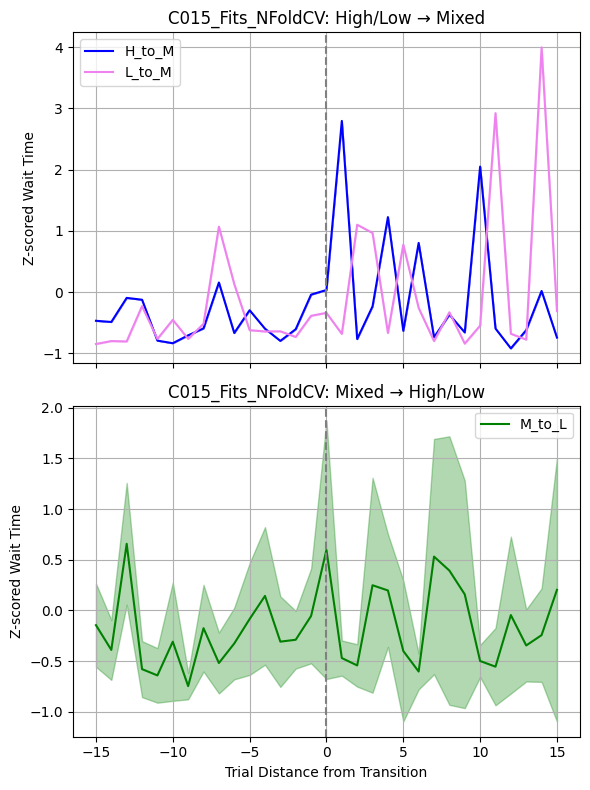

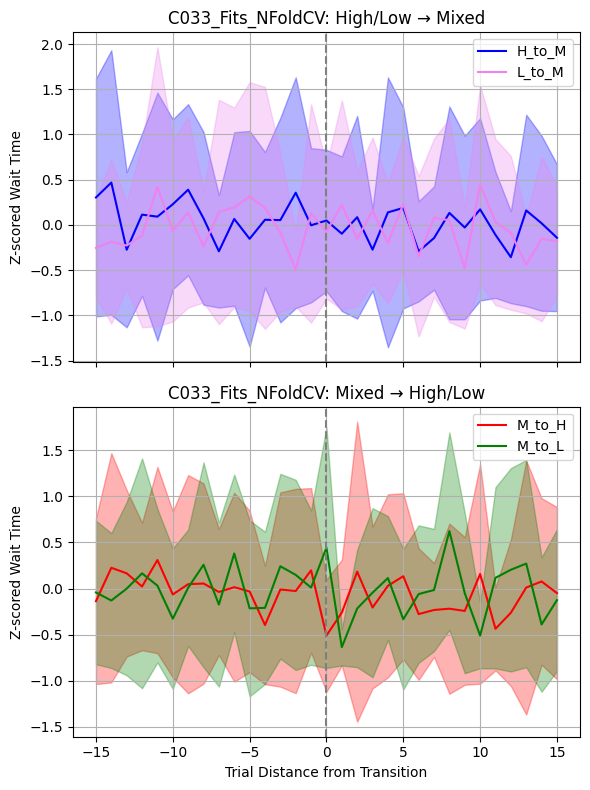

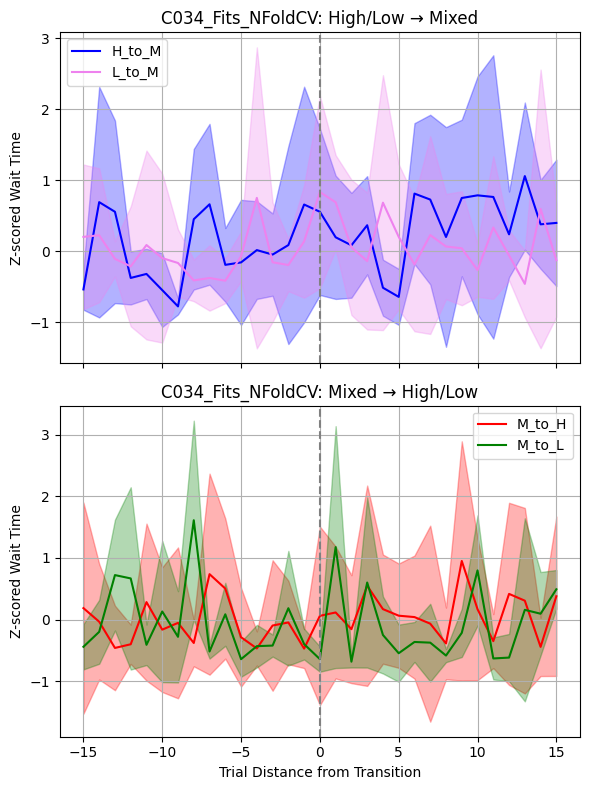

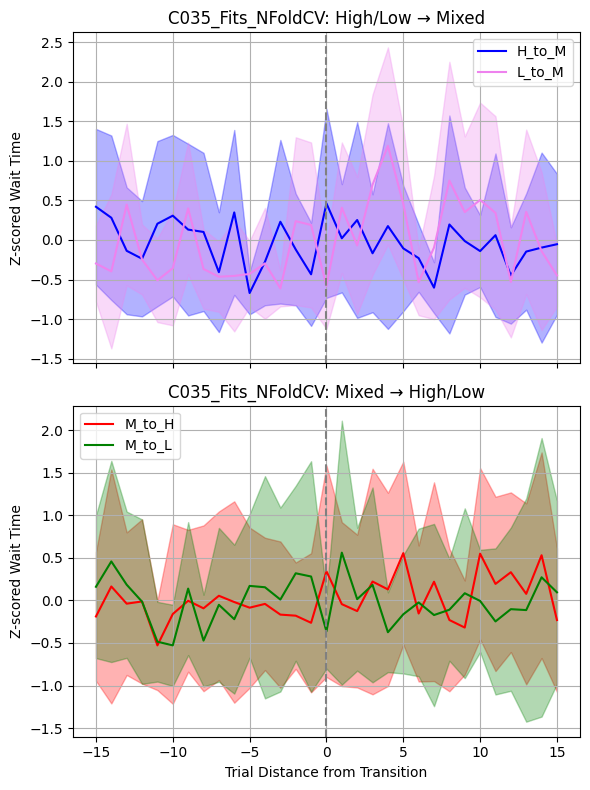

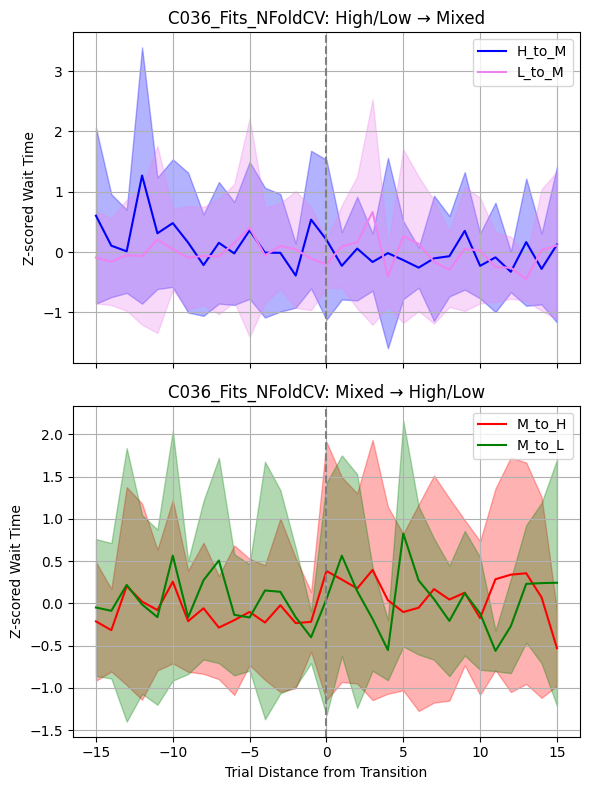

/var/folders/54/6j5bswxd737_q17mf8979d8mgk3r9g/T/ipykernel_56178/2286358083.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/var/folders/54/6j5bswxd737_q17mf8979d8mgk3r9g/T/ipykernel_56178/2286358083.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


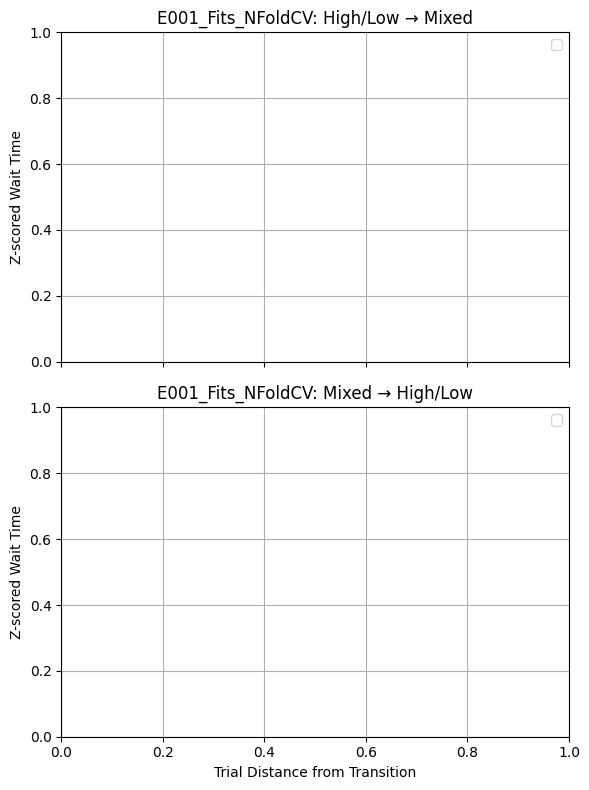

In [8]:
shown = 0

for rat, tdict in aligned_z_waits.items():
    if shown >= 6:
        break
    fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # High/Low → Mixed
    for ttype, color in zip(['H_to_M', 'L_to_M'], ['blue', 'violet']):
        arrs = [arr for arr in tdict[ttype] if len(arr) == 2 * max_trials + 1]
        if len(arrs) == 0:
            continue
        mat = np.stack(arrs)
        mean = np.nanmean(mat, axis=0)
        std = np.nanstd(mat, axis=0)
        axs[0].plot(x_vals, mean, label=ttype, color=color)
        axs[0].fill_between(x_vals, mean - std, mean + std, alpha=0.3, color=color)

    axs[0].set_title(f"{rat}: High/Low → Mixed")
    axs[0].axvline(0, color='gray', linestyle='--')
    axs[0].legend()
    axs[0].grid(True)

    # Mixed → High/Low
    for ttype, color in zip(['M_to_H', 'M_to_L'], ['red', 'green']):
        arrs = [arr for arr in tdict[ttype] if len(arr) == 2 * max_trials + 1]
        if len(arrs) == 0:
            continue
        mat = np.stack(arrs)
        mean = np.nanmean(mat, axis=0)
        std = np.nanstd(mat, axis=0)
        axs[1].plot(x_vals, mean, label=ttype, color=color)
        axs[1].fill_between(x_vals, mean - std, mean + std, alpha=0.3, color=color)

    axs[1].set_title(f"{rat}: Mixed → High/Low")
    axs[1].axvline(0, color='gray', linestyle='--')
    axs[1].legend()
    axs[1].grid(True)

    axs[0].set_ylabel("Z-scored Wait Time")
    axs[1].set_ylabel("Z-scored Wait Time")
    axs[1].set_xlabel("Trial Distance from Transition")

    plt.tight_layout()
    plt.show()
    shown += 1

In [9]:
# add column for each transition type 
prev_block = [ 1,        1,         2,        3]
curr_block = [ 2,        3,         1,        1]
tname =    ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']

# get block switches
b0 = combined_df['block'].values[:-1]
b1 = combined_df['block'].values[1:]

# find where block transitions occur
switches = np.where(b0 != b1)[0] + 1  # +1 to account for the shift in the array

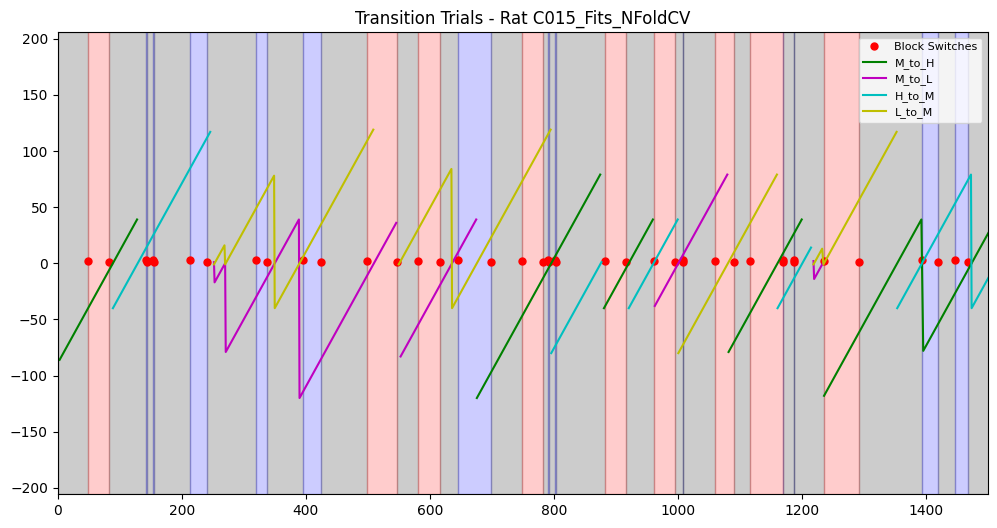

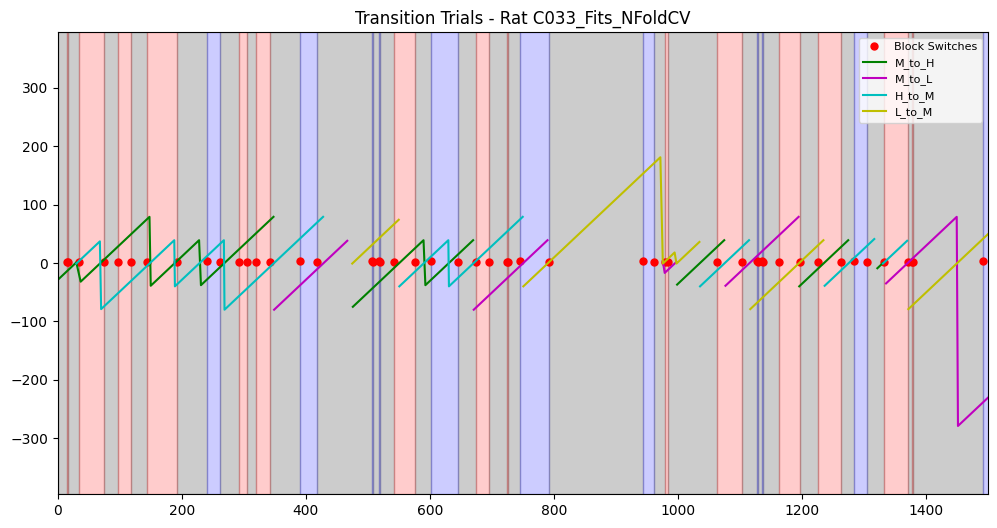

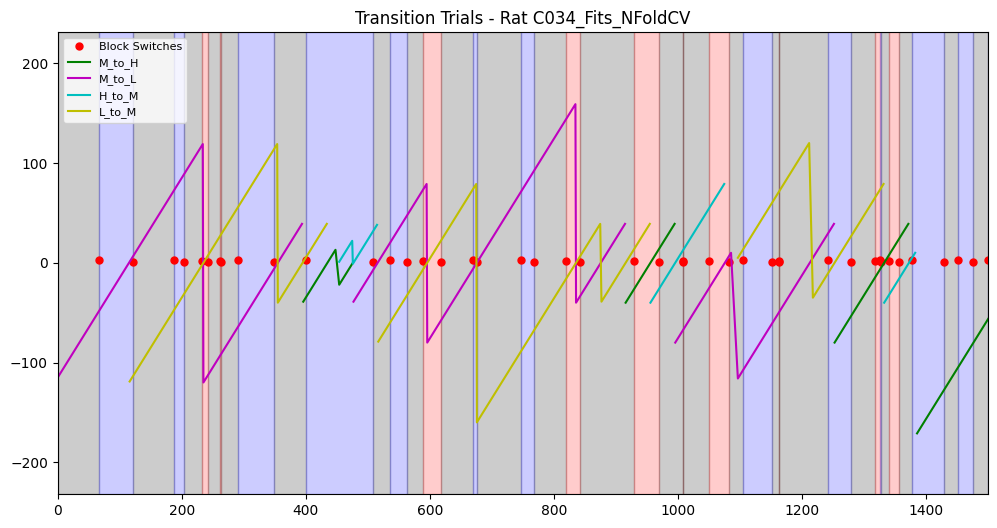

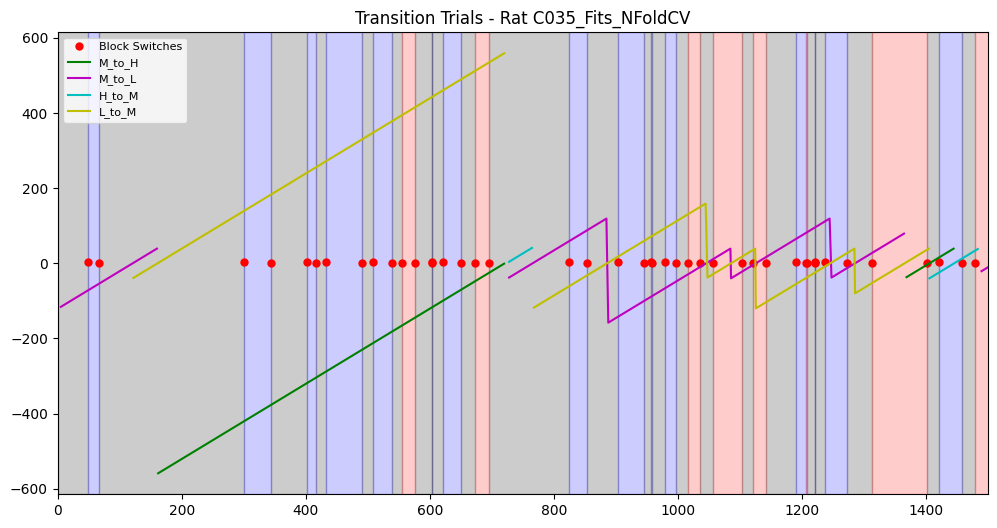

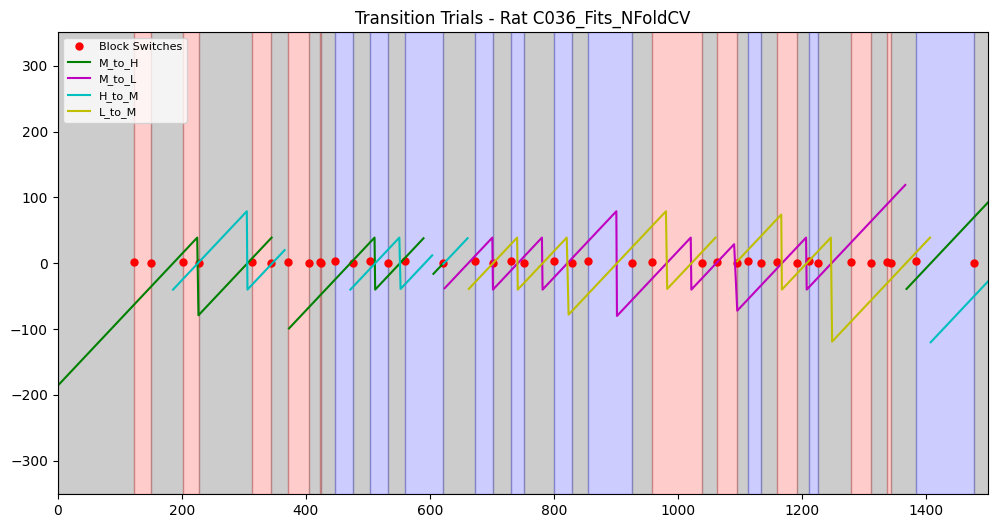

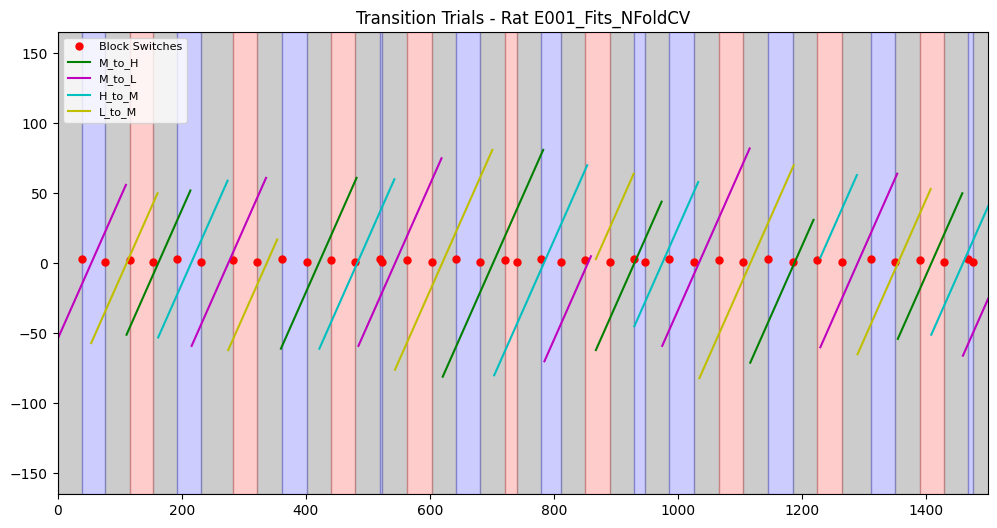

In [10]:
# plotting the transition trials
shown = 0
for rat_id, data in all_rat_data.items():
    if shown >= 6:
        break
    
    # calculate switches for this specific rat's data
    b0 = data['block'].values[:-1]
    b1 = data['block'].values[1:]
    switches = np.where(b0 != b1)[0] + 1
    
    # only plot switches that are within bounds
    valid_switches = switches[switches < len(data)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(valid_switches, data['block'].values[valid_switches], 'ro', markersize=5, label='Block Switches')
    
    # fill background colors for each block
    unique_blocks = data['block'].unique()
    block_colors = {1: 'black', 2: 'red', 3: 'blue'}
    for i, t0 in enumerate(valid_switches):
        if i == 0:
            plt.axvspan(0, t0, color=block_colors[data['block'].values[0]], alpha=0.2)
        else:
            plt.axvspan(valid_switches[i-1], t0, color=block_colors[data['block'].values[t0-1]], alpha=0.2)
    
    # plot the distances to transitions (if these columns exist in data)
    if 'M_to_H' in data.columns:
        plt.plot(data['M_to_H'], 'g', label='M_to_H')
    if 'M_to_L' in data.columns:
        plt.plot(data['M_to_L'], 'm', label='M_to_L')
    if 'H_to_M' in data.columns:
        plt.plot(data['H_to_M'], 'c', label='H_to_M')
    if 'L_to_M' in data.columns:
        plt.plot(data['L_to_M'], 'y', label='L_to_M')
    
    plt.xlim(0, min(1500, len(data)))
    plt.title(f'Transition Trials - Rat {rat_id}')
    plt.legend(fontsize=8)
    plt.show()
    shown += 1

In [12]:
# apply get_transition_dynamics_from_df function to each rat's data
shown = 0
for rat_id, data in all_rat_data.items():
    if shown >= 6:
        break
    data_copy = data.reset_index(drop=True).copy()
    
    get_transition_dynamics_from_df(data_copy)

    transition_cols = ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']
    for col in transition_cols:
        data[col] = data_copy[col].values

    shown += 1

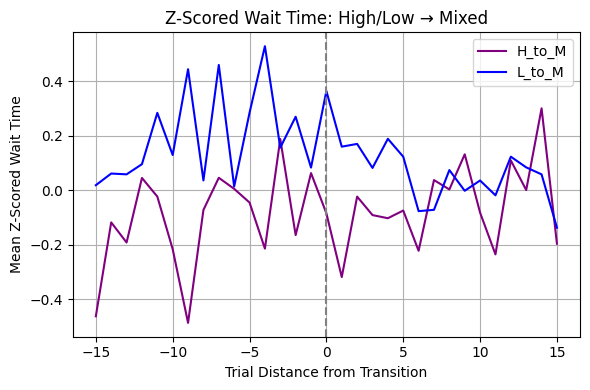

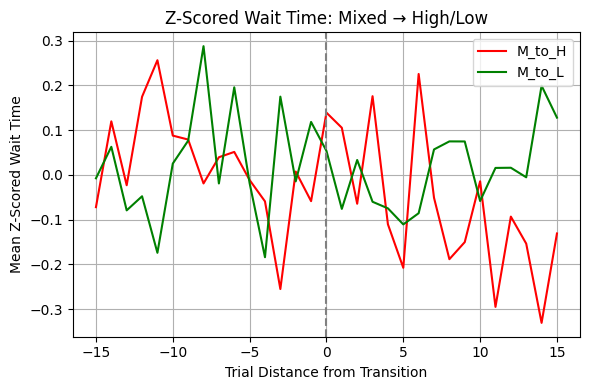

In [13]:
all_dynamics = []
shown = 0

for rat, data in all_rat_data.items():
    if shown >= 6:
        break
    
    data_copy = data.reset_index(drop=True).copy()
    
    get_transition_dynamics_from_df(data_copy)
    
    tname = ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']
    max_trials = 15
    ntrials = 2 * max_trials + 1
    nttypes = len(tname)
    z_wait_times = np.empty((ntrials, nttypes))
    z_wait_times.fill(np.nan)

    for i, t in enumerate(tname):
        trials_to_use = data_copy[
            (~data_copy['z_wait_time'].isna()) &
            (~data_copy[t].isna()) &
            (data_copy[t] >= -max_trials) &
            (data_copy[t] <= max_trials)
        ].index

        distances = data_copy.loc[trials_to_use, t].values.astype(int)
        z_scores = data_copy.loc[trials_to_use, 'z_wait_time'].values

        for d in range(-max_trials, max_trials + 1):
            mask = distances == d
            if np.any(mask):
                z_wait_times[d + max_trials, i] = z_scores[mask].mean()
    
    all_dynamics.append(z_wait_times)
    shown += 1

# average across rats
avg_z_dynamics = np.nanmean(np.stack(all_dynamics), axis=0)

# plot: High and Low to Mixed (H_to_M and L_to_M)
plt.figure(figsize=(6, 4))
x_vals = np.arange(-15, 16)
plt.plot(x_vals, avg_z_dynamics[:, 2], label='H_to_M', color='purple')
plt.plot(x_vals, avg_z_dynamics[:, 3], label='L_to_M', color='blue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Trial Distance from Transition')
plt.ylabel('Mean Z-Scored Wait Time')
plt.title('Z-Scored Wait Time: High/Low → Mixed')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plot: Mixed to High and Low (M_to_H and M_to_L)
plt.figure(figsize=(6, 4))
plt.plot(x_vals, avg_z_dynamics[:, 0], label='M_to_H', color='red')
plt.plot(x_vals, avg_z_dynamics[:, 1], label='M_to_L', color='green')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Trial Distance from Transition')
plt.ylabel('Mean Z-Scored Wait Time')
plt.title('Z-Scored Wait Time: Mixed → High/Low')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()